In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from funcs import *
from AStar import *
from Dijkstra import *
from tabu_search import *
from DataPreprocessing import *







### 1. Wstęp ###


W ramach zadania zaimplementowano algorytmy wyszukiwania optymalnych tras w komunikacji miejskiej Wrocławia. Zrealizowano dwa główne zadania:

Wyszukiwanie najkrótszych połączeń między dwoma przystankami (A i B) z optymalizacją według czasu przejazdu lub liczby przesiadek
Wyszukiwanie najkrótszej trasy prowadzącej przez wszystkie przystanki z zadanej listy, rozpoczynającej się i kończącej w punkcie A (wariant problemu komiwojażera)

Każde z zadań zostało zrealizowane przy użyciu odpowiednich technik algorytmicznych, w tym algorytmu Dijkstry, algorytmu A* oraz metaheurystyki przeszukiwania Tabu.

### 2. Wykorzystane biblioteki ###

Pandas - Wykorzystany do wczytywania i przetwarzania danych z pliku CSV zawierającego informacje o połączeniach komunikacji miejskiej

Heapq - Implementacja kolejki priorytetowej, niezbędnej w algorytmach Dijkstry

### 3. Opis algorytmów ###

Główne założenia:
- Sparsowano dane z pliku CSV (*DataPreprocessing.py*) do postaci grafu, którego nazywano później *Adjacency* (*funcs.py/build_adjacency*)
- Graf ma strukturę: {Nazwa_przystanku: {(linia,nastepny_przystanek): [(czas_odjazdu,czas_przyjazdu)]}}
- Graf o takiej strukturze bardzo zawęża możliwości wyboru linii, gdyż nie trzeba sprawdzać wszystkich odjazdów, ale ograniczyć się do po jednym odjeździe z każdej linii, w obu kierunkach.
- Do wyszukania "łapalnych" (Catchable) połączeń użyto funkcji *funcs.py/get_neighbours*

### 3.0  budowa grafu ###

In [2]:
df = data_preprocessing(csv_file_name)
adjacency, station_coords = build_adjacency(df)
with open("graph.pickle", "wb") as f:
    pickle.dump((adjacency, station_coords), f)

C:\Users\Mikolaj\PycharmProjects\Sztuczna\JakDojade\DataPreprocessing.py:10: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_filename)


In [3]:
 with open("graph.pickle", "rb") as f:
        adjacency, station_coords = pickle.load(f)


In [4]:
START_STATION = 'Przyjaźni'
END_STATION = 'Piastowska'
START_TIME_STR = "19:00:00"
START_TIME = parse_time(START_TIME_STR)

#### 3.1 Wyszukiwanie najkrótszych połączeń między dwoma przystankami ####

### 3.1.1 Dijkstra ###

*Implementacja algorytmu Dijkstry, jak i pozostałych, znajduje się w odpowiednim pliku .py*




Algorytm Dijkstry to klasyczny algorytm znajdowania najkrótszych ścieżek w grafie ważonym o nieujemnych wagach. Główna idea algorytmu:

1. Inicjalizacja: odległość do węzła startowego = 0, do pozostałych węzłów = nieskończoność
2. Utrzymywanie zbioru odwiedzonych węzłów i kolejki priorytetowej węzłów do odwiedzenia
3. W każdej iteracji wybierany jest węzeł o najmniejszej odległości od źródła
4. Aktualizowane są odległości do sąsiadów wybranego węzła
5. Algorytm kończy się, gdy wszystkie węzły zostały odwiedzone lub gdy osiągnięto węzeł docelowy

In [5]:
end_node = dijkstra(adjacency,START_STATION, END_STATION, START_TIME)

In [6]:
print_whole_stats(end_node,
                      start_station=START_STATION,
                      end_station=END_STATION,
                      start_time=START_TIME,
                      )

AttributeError: 'tuple' object has no attribute 'parent'

### 3.1.2 A* ###

Algorytm A* rozszerza algorytm Dijkstry o heurystykę, która kieruje przeszukiwanie w stronę celu. Kluczowe elementy:

1. Funkcja oceny f(n) = g(n) + h(n), gdzie:
    a) g(n) to dotychczasowy koszt dotarcia do węzła n
    b) h(n) to heurystyczne oszacowanie kosztu dotarcia z węzła n do celu. Użyto haversine distance, czyli odległości między dwoma punktami na sferze. Potem wyliczono szacunowy czas przejazdu przyjmując 20 km/h jako średnią prędkość.


2. A* wykorzystuje dwie listy: otwartą (węzły do odwiedzenia) i zamkniętą (węzły odwiedzone)
W każdej iteracji wybierany jest węzeł z listy otwartej o najniższej wartości f(n)
Generowani są następnicy wybranego węzła i dodawani do listy otwartej
Algorytm kończy się, gdy cel zostanie osiągnięty lub lista otwarta będzie pusta


3. Tryby:
    a) Dla optymalizacji czasu przejazdu: brak kary za przesiadki
    b) Dla optymalizacji liczby przesiadek: kara za przesiadkę 1800 sekund


4. Uwagi ogólne:
    a) Przyjęto, że na przesiadkę trzeba poczekać conajmniej 2 minuty.



### 3.1.2.1 Modyfikacja A*

Zawężono wyszukiwanie sąsiadów jedynie do unikalnych par (linia, kierunek). Pozwoliło to na obniżenie czasu obliczeń 20 razy, z około 3.7 sekund do 0.2 sekundy.

In [ ]:
end_node = a_star_proper(START_STATION, END_STATION, START_TIME,mode="TRANSFERS")

In [ ]:
print_whole_stats(end_node,
                      start_station=START_STATION,
                      end_station=END_STATION,
                      start_time=START_TIME,
                      )

In [ ]:
end_node = a_star_proper(START_STATION, END_STATION, START_TIME,mode="TIME")

In [ ]:
print_whole_stats(end_node,
                      start_station=START_STATION,
                      end_station=END_STATION,
                      start_time=START_TIME,
                      )

### 3.2 Problem komiwojażera ###

3.2.1 Opis teoretyczny


*3.2.1.1 Problem komiwojażera (TSP)*

Problem komiwojażera (Traveling Salesman Problem, TSP) polega na znalezieniu najkrótszej trasy odwiedzającej wszystkie zadane punkty dokładnie raz i wracającej do punktu początkowego. Jest to klasyczny problem NP-trudny, co oznacza, że nie istnieje algorytm wielomianowy rozwiązujący go optymalnie dla dowolnych danych wejściowych.
W kontekście komunikacji miejskiej problem sprowadza się do znalezienia optymalnej trasy prowadzącej przez zadane przystanki, minimalizującej łączny czas przejazdu lub liczbę przesiadek.


*3.2.1.2 Przeszukiwanie Tabu (Tabu Search)*

Kluczowe elementy:

Lista Tabu: Przechowuje ruchy, które są tymczasowo zabronione, aby uniknąć cykli i zakleszczenia w lokalnych minimach
Definiowanie sąsiedztwa: Określa zbiór możliwych ruchów z bieżącego rozwiązania
Kryterium aspiracji: Pozwala na wykonanie ruchu z listy Tabu, jeśli prowadzi on do rozwiązania lepszego niż najlepsze znane


*3.2.2 Modyfikacje algorytmu przeszukiwania Tabu*




- Dynamiczne dostosowanie rozmiaru listy Tabu: Jest ona zależna od dlugości listy przystanków (3 * n)

- Implementacja mechanizmu aspiracji: Jeżeli ruch jest w tabu i jest lepszy niż obecny plus epsilon aspiracji, wtedy i tak bierzemy ten ruch
- Strategie próbkowania sąsiedztwa: Wybrano stałą liczbę sąsiadów, którą można wygenerować z bieżącego rozwiązania (10)

### 3.2.3 Napotkane problemy ###

1. Przy długiej trasie, przekraczającej kilkanaście godzin, algorytm kończył działanie, kończył mu się czas
2. Odpowiednie wykrywanie braku przesiadek, aby zaliczyć 2 przejazdy jedną linią
3. Odpowiedni wykrywanie przesiadki na zawracaniu (np. na pętli)
4. Cachowanie wyników, aby zaoszczećić czas obliczeń. Cache'owanie wyników dla samego algorytmu A*, jak i dla permutacji w tabu_search
5. Odpowiednie wybieranie sąsiadów w tabu_search, aby nie wybierać wszystkich sąsiadów, ale jedynie część.

In [ ]:
start_station= "KRZYKI"
stations_string = "Kliniki - Politechnika Wrocławska;BISKUPIN;Stalowa;Krucza;rondo Św. Ojca Pio;most Grunwaldzki;SĘPOLNO"
START_TIME_STR = "06:40:00"
START_TIME = parse_time(START_TIME_STR)
best_solution, best_cost,route_cache = tabu_search(start_station,stations_string,START_TIME,mode="TIME")

decode_and_print_solution(
                            route_cache=route_cache,
                            start_station=start_station,
                            stations_string=stations_string,
                            solution=best_solution,
                            start_time=START_TIME,



                          )

### PRZYKŁADY ###


In [8]:
# Dane do pojedynczych wycieczek:

single_examples_list = [
    ("Piastowska","Przyjaźni","19:00:00"),
    ("most Grunwaldzki","Kochanowskiego","06:40:00"),
    ("Stalowa","KRZYKI","15:40:00"),
    ("SĘPOLNO","Bajana","15:00:00"),
    ("Bielany Wrocławskie - Kwiatowa","Psie Pole (Rondo Lotników Polskich)","10:00:00")

]

tsp_examples_list = [
    ("KRZYKI","most Grunwaldzki;Kochanowskiego;Wiśniowa;PL. JANA PAWŁA II","10:00:00"),
    ("Bajana","GRABISZYŃSKA (Cmentarz);ZOO;Urząd Wojewódzki (Muzeum Narodowe);most Grunwaldzki;Kochanowskiego;Wiśniowa;PL. JANA PAWŁA II","11:00:00"),
    ("Stalowa","GRABISZYŃSKA (Cmentarz);Fiołkowa;FAT;Hutmen;Bzowa (Centrum Historii Zajezdnia)","15:40:00"),
    ("Katedra","Kliniki - Politechnika Wrocławska;BISKUPIN;Stalowa;Krucza;rondo Św. Ojca Pio;most Grunwaldzki;SĘPOLNO","06:00:00"),
    ("Stalowa","Tarczyński Arena (Lotnicza);Niedźwiedzia;Bujwida;PARK POŁUDNIOWY;Na Niskich Łąkach;BISKUPIN","11:40:00"),
    ]




In [40]:
#Dijkstra
dijkstra_results ={}
astar_time_results ={}
astar_transfers_results ={}
dict_list=[dijkstra_results,astar_time_results,astar_transfers_results]
alg_names =["Dijkstra","A* - Time","A* - Transfers"]
for example in single_examples_list:
    start,end,time = example
    nodes_visited,edges_seen,end_node = dijkstra(adjacency,start,end,parse_time(time))
    dijkstra_results[example] = (nodes_visited,edges_seen,end_node)
    nodes_visited,edges_seen,end_node = a_star_proper(start,end,parse_time(time),mode="TIME")
    astar_time_results[example] = (nodes_visited,edges_seen,end_node)
    nodes_visited,edges_seen,end_node = a_star_proper(start,end,parse_time(time),mode="TRANSFERS")
    astar_transfers_results[example] = (nodes_visited,edges_seen,end_node)
    


In [27]:
dijkstra_results

{('Piastowska', 'Przyjaźni', '19:00:00'): (3130,
  76608,
  Node(Przyjaźni, g=60, total=2880,arrival=71280, h=0, f=2880, current_line= 17)),
 ('most Grunwaldzki', 'Kochanowskiego', '06:40:00'): (7,
  235,
  Node(Kochanowskiego, g=180, total=360,arrival=24360, h=0, f=360, current_line= D)),
 ('Stalowa', 'KRZYKI', '15:40:00'): (354,
  9196,
  Node(KRZYKI, g=180, total=1080,arrival=57480, h=0, f=1080, current_line= 6)),
 ('SĘPOLNO', 'Bajana', '15:00:00'): (2345,
  55870,
  Node(Bajana, g=60, total=2700,arrival=56700, h=0, f=2700, current_line= 22)),
 ('Bielany Wrocławskie - Kwiatowa',
  'Psie Pole (Rondo Lotników Polskich)',
  '10:00:00'): (2583,
  60737,
  Node(Psie Pole (Rondo Lotników Polskich), g=60, total=5160,arrival=41160, h=0, f=5160, current_line= N))}

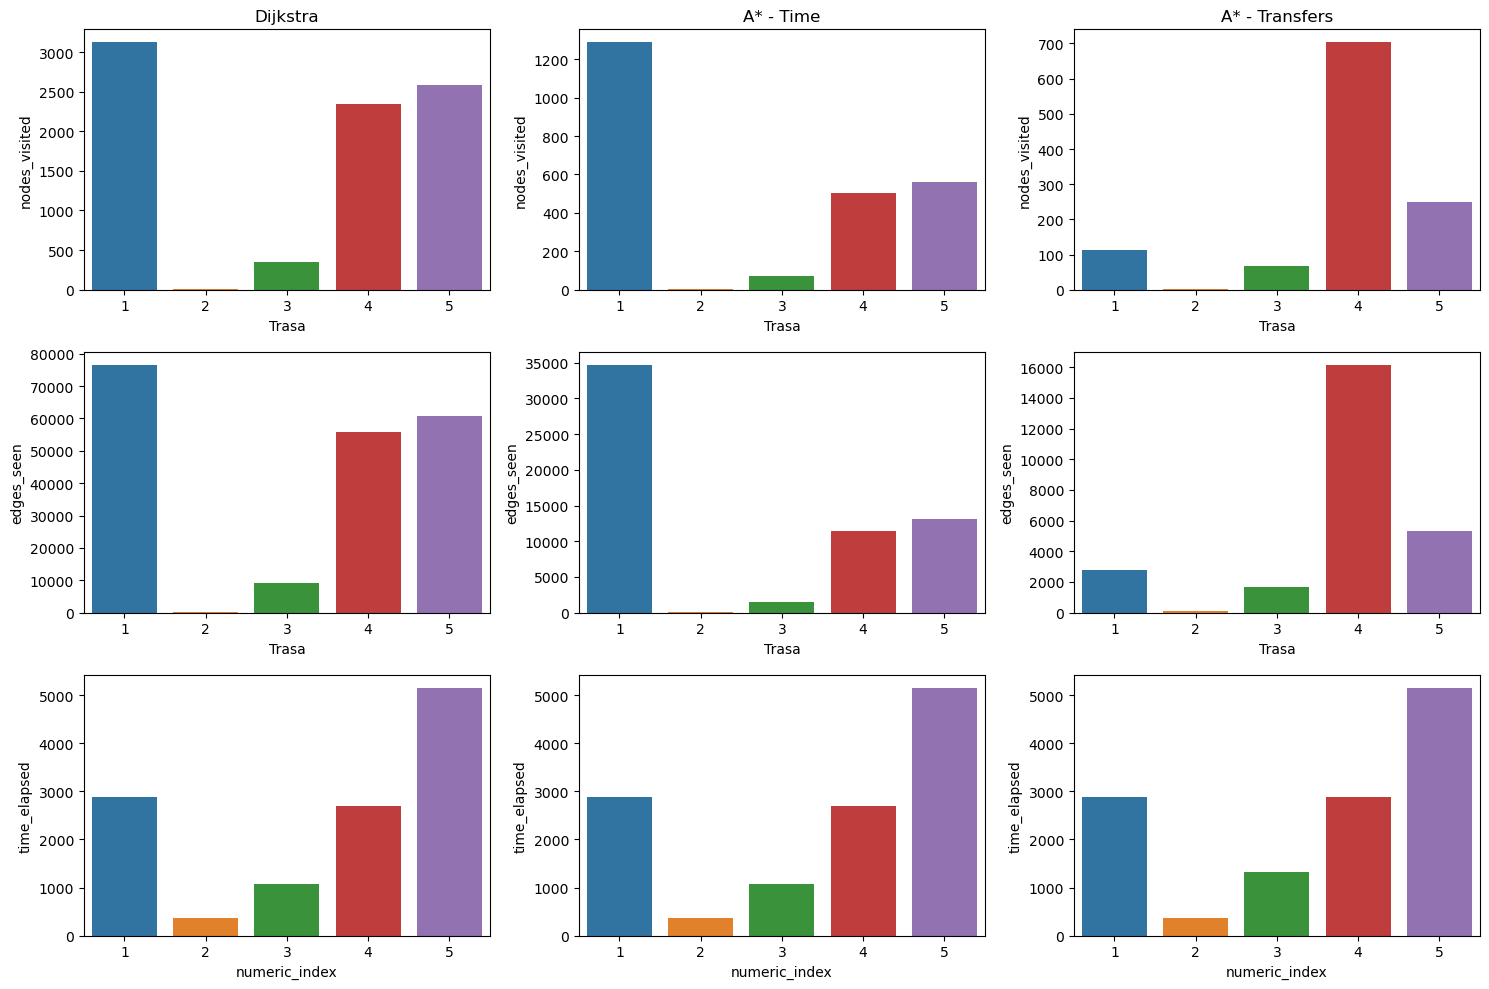

In [45]:
fig,ax = plt.subplots(3,3,figsize=(15,10))



for i,rdict in enumerate(dict_list):
    data_rows = []
    for (key1, key2, start_time_str), (nodes_visited, edges_seen, node_obj) in rdict.items():
    
        time_elapsed = node_obj.arrival_time - parse_time(start_time_str)
        data_rows.append({
            'Key1': key1,
            'Key2': key2, 
            'start_time_str': start_time_str,
            'nodes_visited': nodes_visited,
            'edges_seen': edges_seen,
            'time_elapsed': time_elapsed
        })
        
    # Convert to DataFrame
    df = pd.DataFrame(data_rows)
    df = df.reset_index(drop=True)
    df['numeric_index'] = df.index + 1  # Start from 1 instead of 0
    
    sns.barplot(x="numeric_index", y="nodes_visited", data=df, ax=ax[0,i])
    sns.barplot(x="numeric_index", y="edges_seen", data=df, ax=ax[1,i])
    sns.barplot(x="numeric_index", y="time_elapsed", data=df, ax=ax[2,i])
    

    
    ax[0,i].set_title(alg_names[i])
    ax[0,i].set_xlabel("Trasa")
    ax[1,i].set_xlabel("Trasa")
plt.tight_layout()

plt.show()
    
    

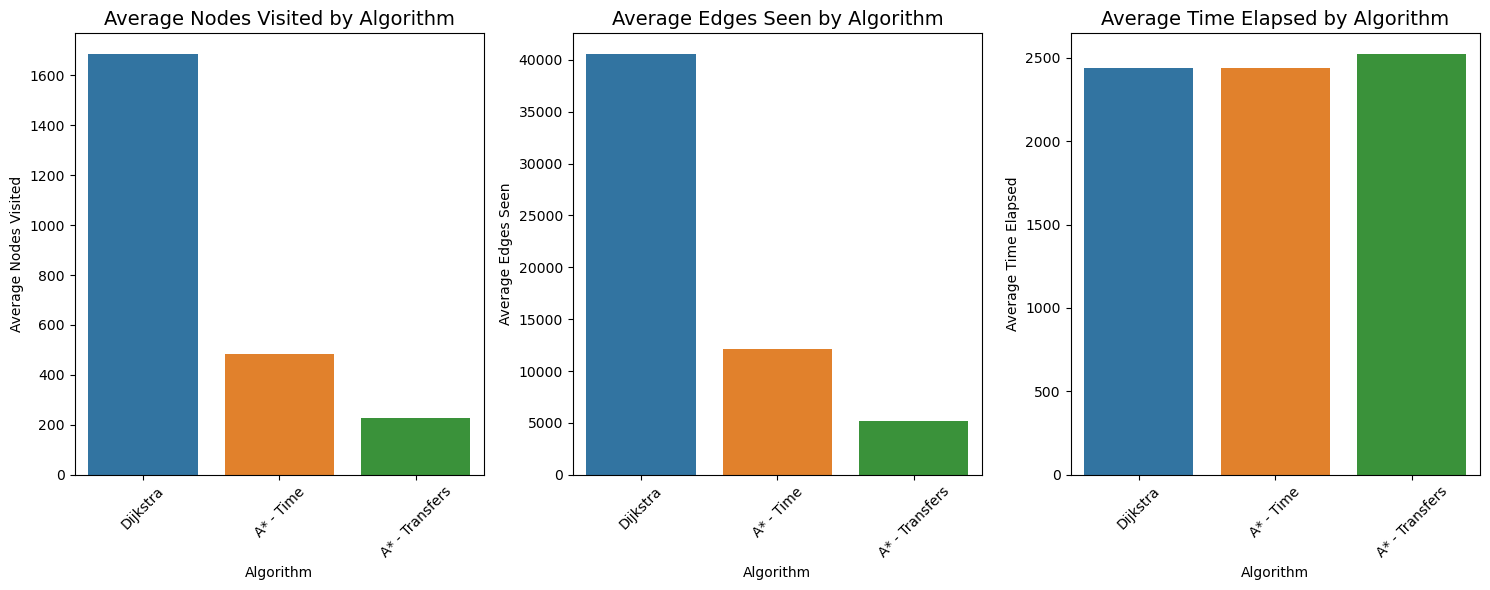

In [44]:
# Create a new figure with 1 row and 2 columns
fig, ax = plt.subplots(1, 3, figsize=(15, 6))


avg_nodes = []
avg_edges = []
avg_time=[]

# Calculate average for each algorithm
for i, rdict in enumerate(dict_list):
    data_rows = []
    for (key1, key2, start_time_str), (nodes_visited, edges_seen, node_obj) in rdict.items():
        time_elapsed = node_obj.arrival_time - parse_time(start_time_str)
        data_rows.append({
            'nodes_visited': nodes_visited,
            'edges_seen': edges_seen,
            'time_elapsed': time_elapsed
        })
    
    # Convert to DataFrame and calculate averages
    df = pd.DataFrame(data_rows)
    avg_nodes.append(df['nodes_visited'].mean())
    avg_edges.append(df['edges_seen'].mean())
    avg_time.append(df['time_elapsed'].mean())

# Create new DataFrames for plotting the averages
avg_data = pd.DataFrame({
    'Algorithm': alg_names,
    'Avg Nodes Visited': avg_nodes,
    'Avg Edges Seen': avg_edges,
    'Avg Time Elapsed': avg_time
})

# Plot the first subplot - Average Nodes Visited
sns.barplot(x='Algorithm', y='Avg Nodes Visited', data=avg_data, ax=ax[0])
ax[0].set_title('Average Nodes Visited by Algorithm', fontsize=14)
ax[0].set_ylabel('Average Nodes Visited')
ax[0].tick_params(axis='x', rotation=45)

# Plot the second subplot - Average Edges Seen
sns.barplot(x='Algorithm', y='Avg Edges Seen', data=avg_data, ax=ax[1])
ax[1].set_title('Average Edges Seen by Algorithm', fontsize=14)
ax[1].set_ylabel('Average Edges Seen')
ax[1].tick_params(axis='x', rotation=45)

# Plot the third subplot - Average Time Elapsed
sns.barplot(x='Algorithm', y='Avg Time Elapsed', data=avg_data, ax=ax[2])
ax[2].set_title('Average Time Elapsed by Algorithm', fontsize=14)
ax[2].set_ylabel('Average Time Elapsed')
ax[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()
    
    

### WNIOSKI
 ###

1. Co ciekawe, algorytm Dijkstry jest zawsze szybszy od A*. Możliwe, że wynika to z faktu, że A* dodatkowo liczy heurystykę, co zwiększa czas obliczeń. Liczba odwiedzonych węzłów jest sporo większa (680 w A* do 3000 Dijkstra).
2. Wprowadzenie modyfikacji grafu jak i wyszukiwaniu sąsiadów pozwoliło na bardzo duże obniżenie czasu obliczeń. Wcześciej algorytm iterował po wszystkich możliwych, łapalnych kursach. Teraz, ogranicza się do unikalnych par (linia, kierunek).
3. Trasa wyznaczana w problemie komiwojażera skutecznie wybiera trasy i potrzebne przesiadki.(Lub skutecznie wykrywa brak potrzeby przesiadki)
4.